In [30]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections

from tqdm import tqdm

import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib
/home/wassname/.pyenv/versions/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [22]:
from src.data.gp_curves import GPCurvesReader
from src.models.model import LatentModel

In [40]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
  # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
          target_x[0, :, 0],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.5,
          facecolor='#65c9f7',
          interpolate=True)

  # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()
    plt.show()

In [24]:

MAX_CONTEXT_POINTS = 50 
random_kernel_parameters=True 

dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)

dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)

In [25]:

model = LatentModel(1, 1, 64, latent_enc_self_attn_type="multihead", det_enc_self_attn_type="multihead",
                   det_enc_cross_attn_type="multihead").cuda()

In [28]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-5)

train: 0 -0.4419
train: 100 -0.7201
train: 200 -0.6412
train: 300 -0.5063
train: 400 -0.1644
train: 500 -0.582
train: 600 -0.611
train: 700 -0.5129
train: 800 -0.8014
train: 900 -0.2514
train: 1000 -0.5613
train: 1100 -0.6807
train: 1200 -0.5827
train: 1300 -0.4333
train: 1400 -0.3385
train: 1500 -0.5888
train: 1600 -0.672
train: 1700 -0.6206
train: 1800 -0.5189
train: 1900 -0.6175
train: 2000 -0.5424
train: 2100 -0.6521
train: 2200 -0.6548
train: 2300 -0.3636
train: 2400 -0.8164
train: 2500 -0.6717
train: 2600 -0.5281
train: 2700 -0.6747
train: 2800 -0.1162
train: 2900 -0.273
train: 3000 -0.7012
train: 3100 -0.6228
train: 3200 -0.7149
train: 3300 -0.3041
train: 3400 -0.03954
train: 3500 -0.3009
train: 3600 -0.5779
train: 3700 -0.3136
train: 3800 -0.5777
train: 3900 -0.6598
train: 4000 -0.5003
train: 4100 -0.6234
train: 4200 -0.7078
train: 4300 -0.6055
train: 4400 -0.7312
train: 4500 -0.2429
train: 4600 0.01354
train: 4700 -0.538
train: 4800 -0.4924
train: 4900 -0.4423
train: 5000 -0.7

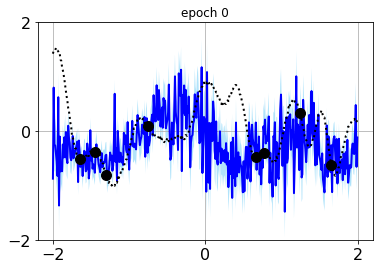

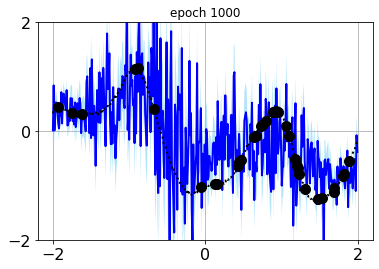

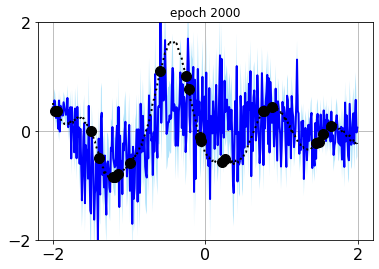

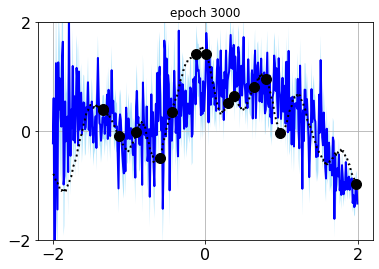

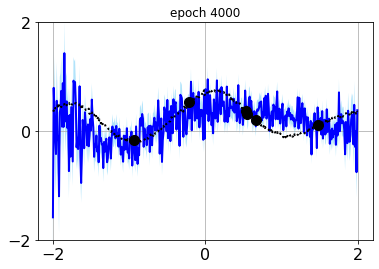

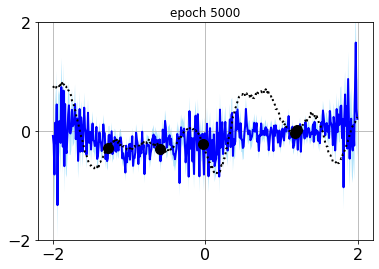

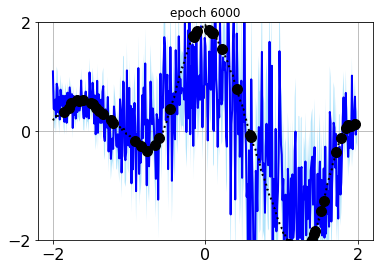

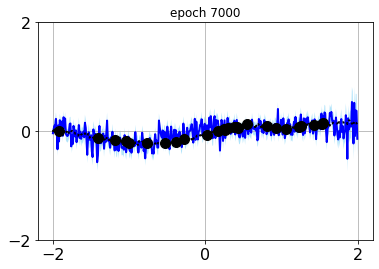

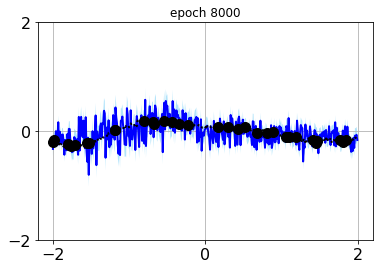

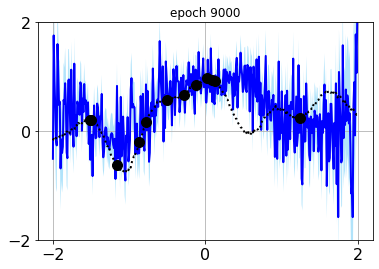

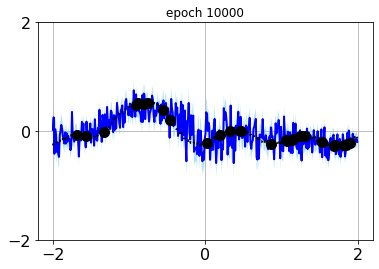

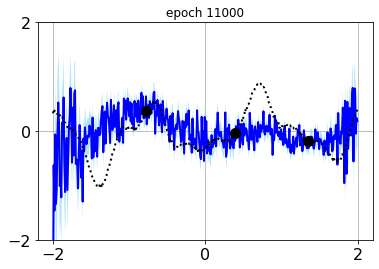

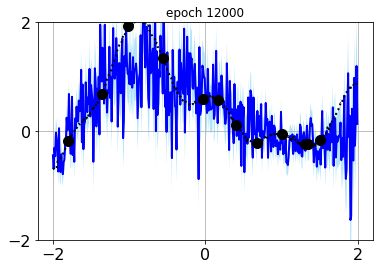

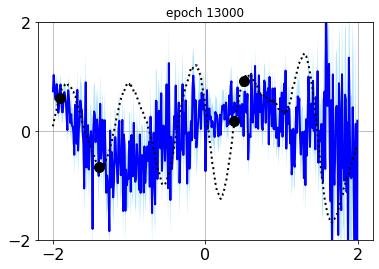

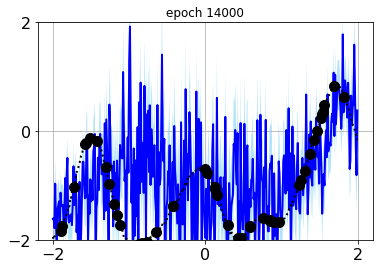

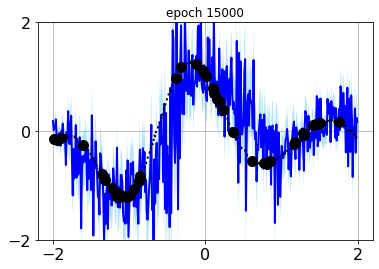

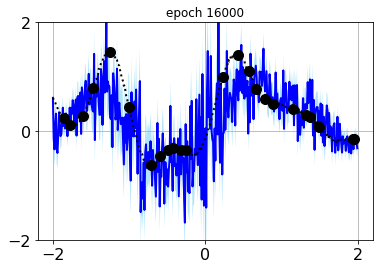

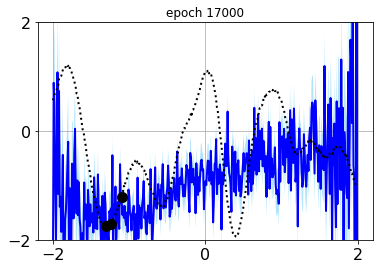

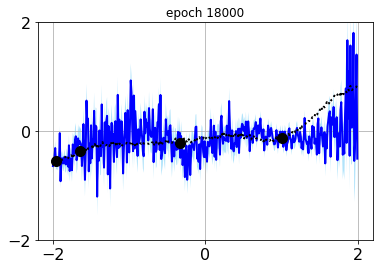

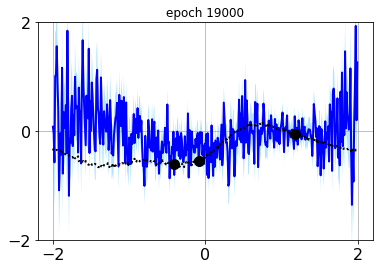

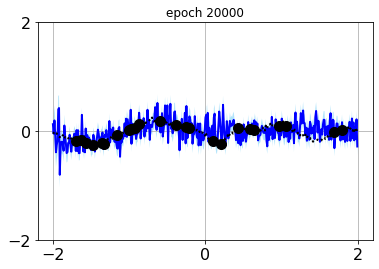

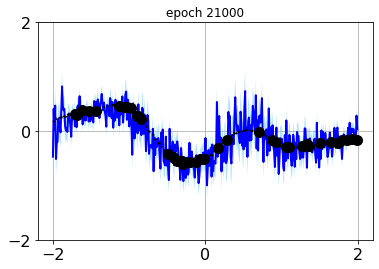

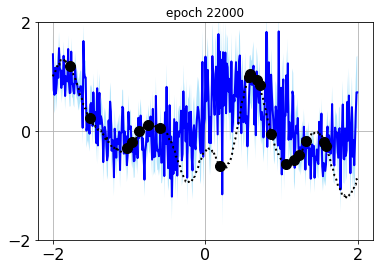

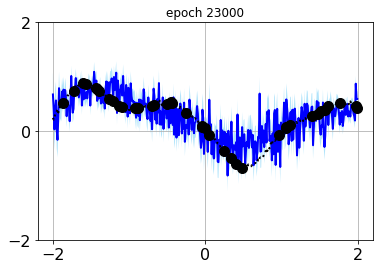

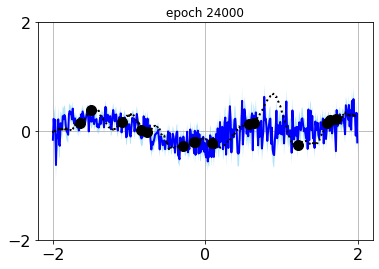

In [43]:
epochs = 100000
for epoch in tqdm(range(epochs)):
    model.train()
    data_train = dataset_train.generate_curves()
    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y
    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, y_std = model(context_x, context_y, target_x, target_y)
    if epoch % 100 == 0:
        print(f"train: {epoch} {loss.item():4.4g}")
    loss.backward()
    optim.step()
    if epoch % 5000 == 0:
        model.eval()
        with torch.no_grad():
            data_test = dataset_test.generate_curves()
            (context_x, context_y), target_x = data_test.query
            target_y = data_test.target_y
            context_x = context_x.cuda()
            context_y = context_y.cuda()
            target_x = target_x.cuda()
            target_y = target_y.cuda()
            y_pred, kl, loss, y_std = model(context_x, context_y, target_x)
            plt.title(f"epoch {epoch}")
            plot_functions(target_x.detach().cpu().numpy(),
                           target_y.detach().cpu().numpy(),
                           context_x.detach().cpu().numpy(),
                           context_y.detach().cpu().numpy(),
                           y_pred.detach().cpu().numpy(),
                           y_std.detach().cpu().numpy())